# 1. Characterizing a transmon qubit - MCC180 lab

## Introduction

In this tutorial we will show how to perform the basic characterization of a transmon qubit using Superconducting Qubit Tools, starting from the first signs of life using resonator spectroscopy, to finding the qubit, measuring the coherence and ending with basic single-qubit gate tuneup.

**--------------- You tasks in this Section ---------------**

Within the each section you can find a few tasks in this format. These can form the center point of your report. Please answer them to the best of your ablity.

**----------------------------------------------------------**

First let's initialize the qblox instruments:

In [3]:
import warnings
import os,sys
#to get the current working directory
directory = os.getcwd()
print(directory)
warnings.simplefilter("ignore") 
from mcc180_init import *

/home/loke/liangyu/project/MCC180_202411


These are the initial qubit parameters that we have measured previously, we will be using qubit 25 for our lab, renamed as q0:

In [4]:
# initial values for the qubit
VNA_resonator_frequencies = {'q00': 7.095796170530159e9}
VNA_qubit_frequencies = {'q00': 5212327240}
q0.name,VNA_resonator_frequencies[q0.name],VNA_qubit_frequencies[q0.name]

('q00', 7095796170.530159, 5212327240)

## First signs of life: resonator spectroscopy

The first step once the sample is cooled down is to identify the resonance frequency of the readout resonator.
For our sample, we have designed the readout resonator to be targeted at aroubd 7.098 GHz.
In order to identify this resonance, we start a heterodyne spectroscopy experiment to look for this resonance.
We want to measure in the "high-power" regime of the resonator as this will yield the best signal to noise.

In our experiments, the parameters of the readout in spectroscopy experiments are controlled by the `spec_ro.parameters`: of the transmon element.
These should already be set to reasonable values to start measuring.

**--------------- You tasks in this Section ---------------**

**1.1** Measure the frequency of the readout resonator. Does it depend on the power of your drive? Please explain your findings here.

**1.2** What is the factor that tells your the coupling strength between your qubit and the readout resonator? Can you calculate it with the measured values here?

**----------------------------------------------------------**

### Finding the resonator

Once we have configured our readout parameters, we can look for the resonator.
Because we are not too sure on the frequency, we will scan from -2 to 2 MHz around the resonance using the `superconducting_qubit_tools.measurement_functions.spectroscopy.measure_heterodyne_spectroscopy`.
This function is part of the `superconducting_qubit_tools.measurement_functions` module, a module containing a library of many common experiments.

In [5]:
frequencies = VNA_resonator_frequencies[q0.name] + np.arange(-2e6, 2e6, 0.05e6)

# Use high power to get a good SNR
# q0.hardware_options.attenuations.ro_output_att(0)
q0.spec_ro.amplitude(0.5)
q0.spec_ro.acq_delay(200e-9)
q0.spec_ro.integration_time(8e-6)
q0.spec_ro.duration(8e-6)

analysis_obj = meas.spectroscopy.measure_heterodyne_spectroscopy(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    frequencies=frequencies,
)

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 ro_freq 
Batch size limit: 80



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

Failed loading dataset with 'h5netcdf' engine. Raised 'KeyError':
    'Unable to synchronously open object (bad object header version number)'
Failed loading dataset with 'netcdf4' engine. Raised 'OSError':
    [Errno -101] NetCDF: HDF error: '/home/loke/quantify-data/20241114/20241114-104014-106-2bdf28-Resonator spectroscopy q00/dataset.hdf5'
Failed loading dataset with 'h5netcdf' engine. Raised 'AttributeError':
    'NoneType' object has no attribute 'attrs'
Failed loading dataset with 'netcdf4' engine. Raised 'OSError':
    [Errno -101] NetCDF: HDF error: '/home/loke/quantify-data/20241114/20241114-104014-106-2bdf28-Resonator spectroscopy q00/dataset.hdf5'


Every measurement function returns an analysis object with the analyzed data of the experiment that was performed.

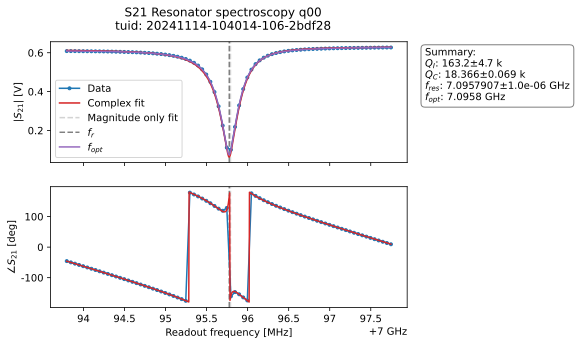

In [6]:
# display the figures containing the analyzed data
# analysis_obj.display_figs_mpl()  # this would plot all figures
analysis_obj.figs_mpl["S21-MagnPhase"]

Let's enter this as our initial guess for what we think the resonator/readout frequency of the qubit is.

In [7]:
q0.clock_freqs.readout(analysis_obj.quantities_of_interest["fr"].nominal_value)
print(f"Readout frequency set to {q0.clock_freqs.readout()/1e9} GHz")

Readout frequency set to 7.095790735805359 GHz


### Going to the low-power regime

In order to use the resonator to read out the state of the qubit, the readout pulse needs to be applied in the low-power regime.
To identify what readout pulse amplitude to use, we perform a heterodyne spectroscopy experiment in which both the power and frequency of the spectroscopy pulse is varied.

For a dispersively coupled resonator, i.e. $|g/\Delta|\ll 1$ where $g$ is the resonator qubit coupling, and $\Delta=\omega_q-\omega_r$ the detuning between the bare qubit and resonator frequencies, the resonator frequency will be slightly shifted, or dressed, due to the coupling of the qubit.
When the resonator is driven with a low power one will observe the dressed resonance frequency $\omega_r^{'} = \omega_r-\frac{g^2}{\Delta-E_C/\hbar}$ as opposed to the bare resonance frequency $\omega_r$ that is observed at high powers.
We call this dispersive shift the power-dependent dispersive shift $\Lambda_{\chi}=\frac{g^2}{\Delta-E_C/\hbar}$, where $E_C/\hbar$ is the anharmonicity of the qubit, which you will measure in the next section.

**Tip**: Dispersive shifts

The power-dependent dispersive shift or Lamb shift is subtly different from the qubit-state dependent dispersive shift

Power-dependent dispersive shift

> $\Lambda_{\chi}=\omega_r - \omega_r^{'} = \frac{g^2}{\Delta-E_C/\hbar}.$

Qubit-state dependent dispersive shift

> $\chi = -\frac{g^2E_c\hbar}{\Delta(\Delta-E_C/\hbar)}.$

For a detailed discussion on dispersive shifts for a dispersively coupled resonator transmon system see section III C of [Blais 2021].


We can measure the power dependence, and thereby the change from the high-power regime to the low-power regime of the resonator using `superconducting_qubit_tools.measurement_functions.spectroscopy.measure_heterodyne_spectroscopy_vs_pulse_amp`. Since we expect a shift to higher frequencies when going from low to high power, we center the spectroscopy frequencies asymmetrically around the previously found (high-power) frequency.

In [8]:
q0.hardware_options.attenuations.ro_output_att(20)
frequencies = VNA_resonator_frequencies[q0.name] + np.arange(-2e6, 2e6, 0.1e6)
amplitudes = np.linspace(0.01, 1, 21)

In [9]:
analysis = meas.spectroscopy.measure_heterodyne_spectroscopy_vs_pulse_amp(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    frequencies=frequencies,
    pulse_amps=amplitudes,
    meas_ctrl=meas_ctrl,
)

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 amplitude 
Batched settable(s):
	 ro_freq 
Batch size limit: 840



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

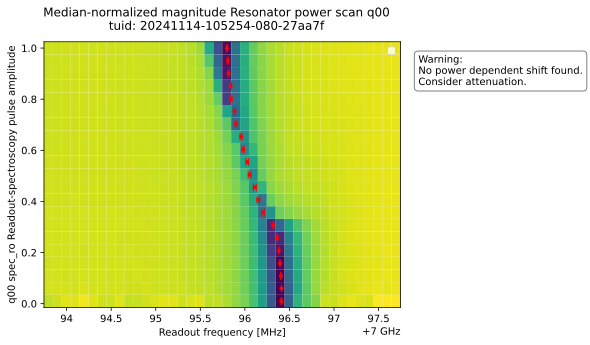

In [10]:
# A heatmap showing the dispersive shifts
analysis.figs_mpl["Heatmap normalized_magnitude"]

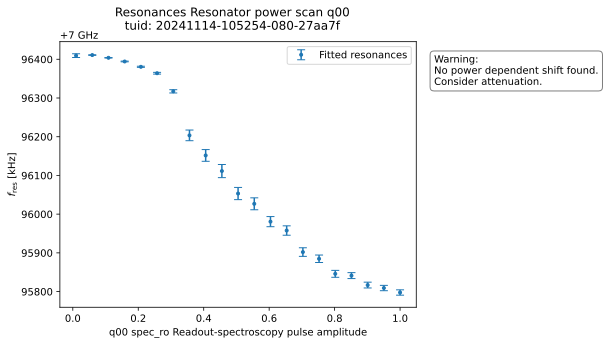

In [11]:
# And the fitted frequencies.
analysis.figs_mpl["frequency_vs_power"]

Based on this experiment, we configure the readout pulse amplitude to be able to operate in the low power regime.
Because the resonance frequency changes, we also need to update the readout frequency to correspond to the resonator frequency in the low power regime.

**Write down what you think is the optimal readout power here:**

In [12]:
readout_amp = 0.08

In [13]:
# Use low power
q0.hardware_options.attenuations.ro_output_att(20)
q0.measure.pulse_amp(readout_amp)
q0.spec_ro.amplitude(readout_amp)
q0.spec_ro.acq_delay(200e-9)
q0.spec_ro.integration_time(8e-6)
q0.spec_ro.duration(8e-6)

In [14]:
frequencies = VNA_resonator_frequencies[q0.name] + np.arange(-2e6, 2e6, 0.05e6)

analysis_obj = meas.spectroscopy.measure_heterodyne_spectroscopy(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    frequencies=frequencies,
)

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 ro_freq 
Batch size limit: 80



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

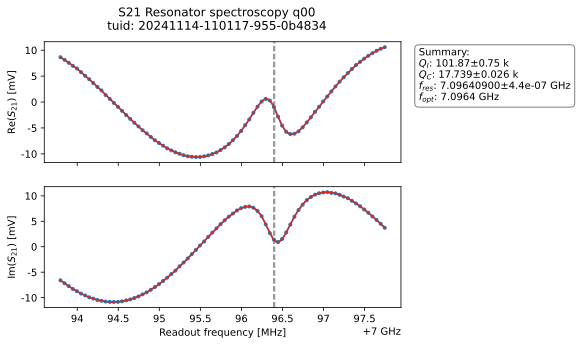

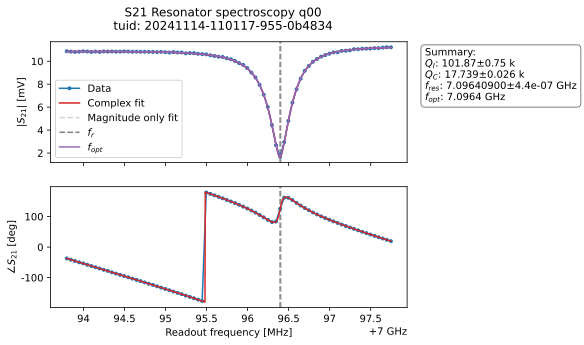

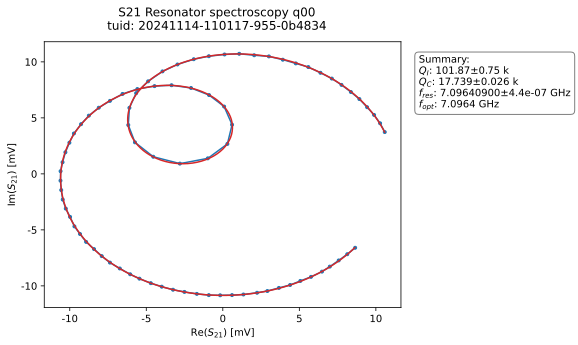

In [15]:
analysis_obj.display_figs_mpl()

Let's enter this as our initial guess for what we think the resonator/readout frequency of the qubit is.

In [22]:
ro_guess = analysis_obj.quantities_of_interest["fr"].nominal_value
q0.clock_freqs.readout(ro_guess)
print(f"Readout frequency set to {q0.clock_freqs.readout()/1e9} GHz")

Readout frequency set to 7.096408999895141 GHz


## Finding the qubit

Now we can start a spectroscopy experiment to identify the qubit frequency. For this purpose we will be performing a two-tone pulsed spectroscopy experiment.


**--------------- You tasks in this Section ---------------**

**1.3** Measure the frequency of the qubit. What happen if it is driven at high power? Please explain your findings here.

**----------------------------------------------------------**

### Qubit spectroscopy

First, we set a pulse duration of 4 us and a relatively low pulse amplitude (power). Because the qubit was designed to be at 5.21 GHz, we sweep the frequency from +/- 20 MHz around this point to see if any resonances can be identified.

In [17]:
q0.measure.pulse_duration(4e-6)
q0.measure.acq_delay(4e-9)
q0.measure.pulse_delay(4e-9)
q0.spec_ro.acq_delay(4e-9)
# q0.hardware_options.attenuations.mw_output_att(34)
q0.spec_mw.amplitude(0.001)
q0.spec_mw.duration(8e-6)
quantum_device.cfg_sched_repetitions(1024*2)

In [24]:
analyzed_pulsed_spec = meas.spectroscopy.measure_two_tone_spectroscopy(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    frequencies=VNA_qubit_frequencies[q0.name]+np.arange(-4e6, 4e6, 0.07e6)
)

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

Failed loading dataset with 'h5netcdf' engine. Raised 'KeyError':
    'Unable to synchronously open object (bad object header version number)'
Failed loading dataset with 'netcdf4' engine. Raised 'OSError':
    [Errno -101] NetCDF: HDF error: '/home/loke/quantify-data/20241114/20241114-112307-498-505de8-Pulsed spectroscopy q00/dataset.hdf5'
Failed loading dataset with 'h5netcdf' engine. Raised 'KeyError':
    'Unable to synchronously open object (addr overflow, addr = 6661, size = 62, eoa = 2048)'
Failed loading dataset with 'netcdf4' engine. Raised 'OSError':
    [Errno -101] NetCDF: HDF error: '/home/loke/quantify-data/20241114/20241114-112307-498-505de8-Pulsed spectroscopy q00/dataset.hdf5'


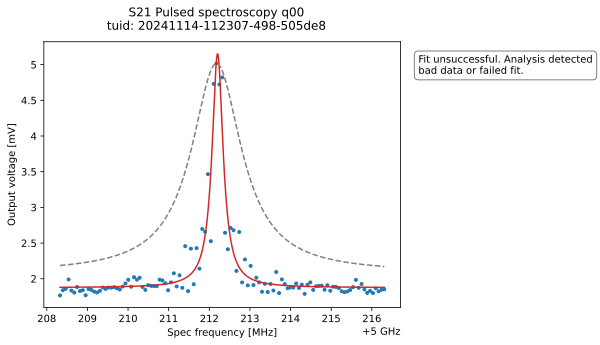

In [25]:
analyzed_pulsed_spec.figs_mpl["qubit_spectroscopy"]

The center of the peak is around 4.2708 GHz. We'll update the frequency in the qubit device element:

In [26]:
f01_guess = analyzed_pulsed_spec.quantities_of_interest["transition_frequency"].nominal_value
q0.clock_freqs.f01(f01_guess)
print(f"Qubit drive frequency set to {q0.clock_freqs.f01()/1e9} GHz")

Qubit drive frequency set to 5.212203774084632 GHz


### Qubit spectroscopy - Power Sweep

A resonance peak is observed around 4.2708 GHz Let's zoom in and sweep the pulse amplitude to see if this could be the qubit.

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

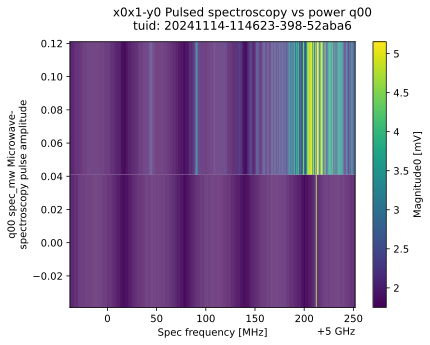

In [31]:
f01_guess = VNA_qubit_frequencies[q0.name]
quantum_device.cfg_sched_repetitions(1024*2)
analyzed_pulsed_spec_vs_pulse_amp = meas.spectroscopy.measure_two_tone_spectroscopy_vs_pulse_amp(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    frequencies=f01_guess+np.arange(-250e6, 40e6, 1.0e6),
    pulse_amps=np.arange(0.001, 0.083, 0.08)
)
analyzed_pulsed_spec_vs_pulse_amp.figs_mpl['Heatmap x0x1-y0']

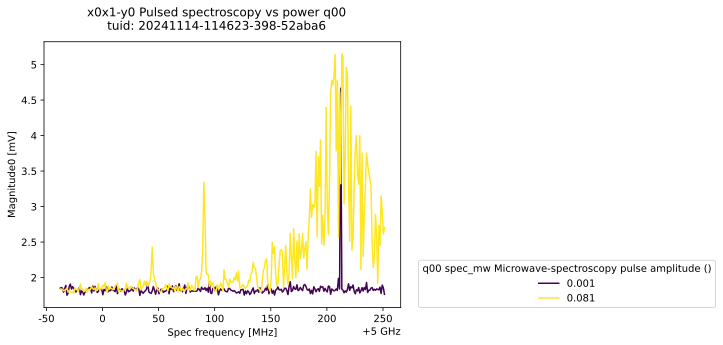

In [32]:
analyzed_pulsed_spec_vs_pulse_amp.figs_mpl['Linecuts x0x1-y0']

We will observe multiple peaks here as we increase the power, which is ~100MHz apart. Note that the x-axis only shows the relative frequency in MHz.

**Which one is the qubit frequency here? And then what is the cause of the other peak? Discuss the answers among your group.**

**Tips:** It only appears at high power, i.e. multiple photons are driving the system. Transmon in reality is more than a two level system, it has many higher energy levels, i.e. 0,1,2,3,.. The anharmonicity (f02-2f01) for this particular qubit is designed to be 200MHz.


Now that we have identified a resonance, we need to verify if this is the qubit.

### A Rabi oscillation

Once we switch over to timedomain experiments, we can configure the parameters of the measure operation.
It is a good idea to start with the parameters that were used to perform the spectroscopy.
These parameters can later be fine-tuned to get a high-fidelity readout.


**--------------- You tasks in this Section ---------------**

**1.4** Find the pi-pulse amplitude of this qubit. What will happen if you drive the qubit off-resonance?

**----------------------------------------------------------**

In [33]:
 q0.clock_freqs.readout(ro_guess)
 q0.clock_freqs.f01(f01_guess)

In [34]:
# ensure we are in the low power regime of the resonator

# this is a relatively long duration for the measurement.
# this is a good starting point when we have not identified the qubit
# and have not had the opportunity to fine-tune the readout.
q0.measure.pulse_amp(readout_amp)
q0.spec_ro.amplitude(readout_amp)
q0.measure.integration_time(4e-6)
q0.measure.pulse_delay(200e-9)
q0.measure.pulse_duration(4e-6)
q0.measure.acq_delay(200e-9)
# We start by using a high power pulse to see if we can identify an oscillation
# q0.hardware_options.attenuations.mw_output_att(16)
quantum_device.cfg_sched_repetitions(1024)

We next configure the parameters of the microwave control pulses used to perform rotations around any axis in the $xy-$plane.
We fix the duration of the control pulses to $20 \mathrm{ns}$.
This pulse duration is commonly used as it is close to the speed-limit set by the presence of the 1-2 transition and it is a nice round number.
For Transmon qubits the 1-2 transition is typically located $\sim E_C \approx 250\mathrm{MHz}$ below the 0-1 transition.
Next, we perform the Rabi experiment by varying the amplitude (power) of the pulses, this has the advantage that all operations (irrespective of rotation angle) have the same duration and spectral properties.

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 mw_G_amp 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

20241114-115315-689-cd3406


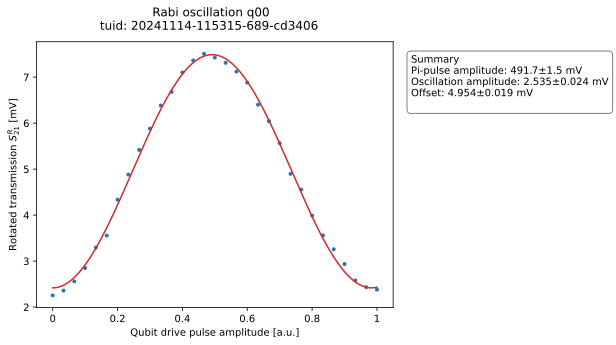

In [35]:
# A commonly used duration for single-qubit operations
q0.reset.duration(600e-6)
q0.clock_freqs.f01(f01_guess)
q0.rxy.duration(20e-9)

analyzed_rabi = meas.single_qubit_timedomain.measure_rabi(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    amplitudes=np.linspace(0, 1.0, 31),
)

print(analyzed_rabi.tuid)
analyzed_rabi.display_figs_mpl()

This measurement shows the pulse amplitude that corresponds to a pi-pulse in the Rabi experiment. We set the amplitude (`q0.rxy.amp180`) for the qubit.

In [36]:
q0.rxy.amp180(analyzed_rabi.quantities_of_interest['Pi-pulse amplitude'].nominal_value)
q0.rxy.amp180()

0.49166426964264

**Now you can modify the frequency detuning between the drive and qubit frequency to observe the effect, what is the difference between 1MHZ, 10MHz, and 20MHz?**

In [37]:
detuning = 1e6 # detuning from the qubit frequency in MHz

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 mw_G_amp 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

20241114-120206-725-25adbd


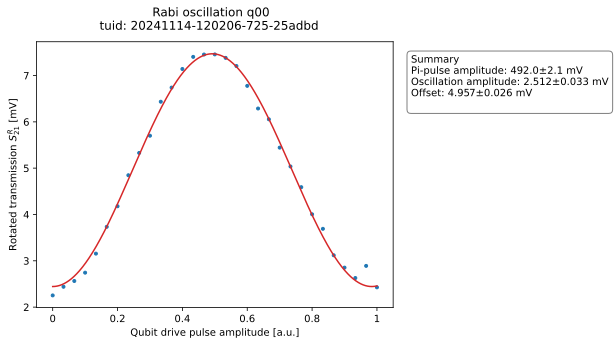

In [38]:
# A commonly used duration for single-qubit operations
q0.reset.duration(600e-6)
q0.clock_freqs.f01(f01_guess + detuning)
q0.rxy.duration(20e-9)

analyzed_rabi = meas.single_qubit_timedomain.measure_rabi(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    amplitudes=np.linspace(0, 1.0, 31),
)

print(analyzed_rabi.tuid)
analyzed_rabi.display_figs_mpl()

In [ ]:
detuning = 30e6 # detuning from the qubit frequency in MHz

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 mw_G_amp 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

20241114-120624-806-c409a9


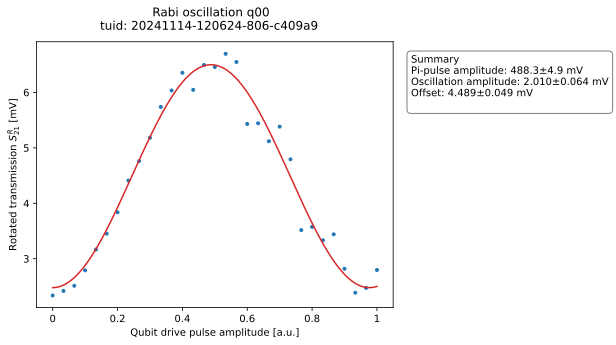

In [44]:
# A commonly used duration for single-qubit operations
q0.reset.duration(600e-6)
q0.clock_freqs.f01(f01_guess + detuning)
q0.rxy.duration(20e-9)

analyzed_rabi = meas.single_qubit_timedomain.measure_rabi(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    amplitudes=np.linspace(0, 1.0, 31),
)

print(analyzed_rabi.tuid)
analyzed_rabi.display_figs_mpl()

In [ ]:
detuning = 60e6 # detuning from the qubit frequency in MHz

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 mw_G_amp 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

20241114-120747-963-843f58


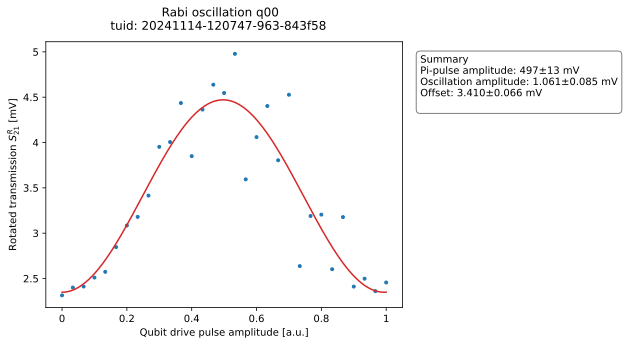

In [46]:
# A commonly used duration for single-qubit operations
q0.reset.duration(600e-6)
q0.clock_freqs.f01(f01_guess + detuning)
q0.rxy.duration(20e-9)

analyzed_rabi = meas.single_qubit_timedomain.measure_rabi(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    amplitudes=np.linspace(0, 1.0, 31),
)

print(analyzed_rabi.tuid)
analyzed_rabi.display_figs_mpl()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 mw_G_amp 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

20241114-121215-072-69be6c


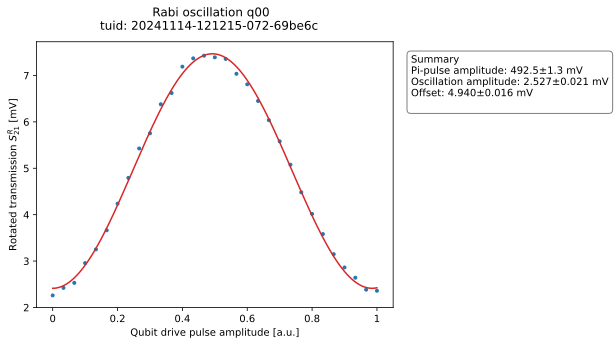

In [47]:
# A commonly used duration for single-qubit operations
q0.reset.duration(600e-6)
q0.clock_freqs.f01(f01_guess)
q0.rxy.duration(20e-9)

analyzed_rabi = meas.single_qubit_timedomain.measure_rabi(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    amplitudes=np.linspace(0, 1.0, 31),
)

print(analyzed_rabi.tuid)
analyzed_rabi.display_figs_mpl()

## Measuring the coherence

Once a Rabi experiment has been performed, we typically want to measure the coherence.

To measure the coherence, one does not need to have perfectly calibrated control-pulses.
A decent $\pi$ pulse is typically sufficient.

**--------------- You tasks in this Section ---------------**

**1.5** Find the T1, T2 and T2 Echo time of your qubit. Can you observe a T2 Echo longer than T2? If so, what does that say about your system? 

**----------------------------------------------------------**

### Relaxation time: $T_1$

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 40



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

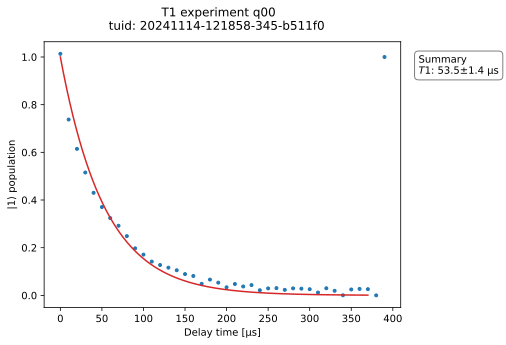

In [48]:
times = np.arange(0e-6, 400e-6, 10e-6)

analysis_t1 = meas.single_qubit_timedomain.measure_t1(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    times=times
)
analysis_t1.display_figs_mpl()


### Ramsey dephasing time $T_2

For the Ramsey experiment, we set the `artificial_detuning` argument to ensure that we will see at least three oscillations, even if we are perfectly on resonance.

The frequency of the oscillations we observe can also be used to fine-tune the frequency detuning, however the detuning we observe will be limited by the sampling rate. For more details see the section on basic gate tuneup later in this tutorial.

In [49]:
quantum_device.cfg_sched_repetitions(1024*2)
q0.clock_freqs.f01(f01_guess)
times = np.arange(40e-9, 15e-6, 0.5e-6)
analysis_ramsey = meas.single_qubit_timedomain.measure_ramsey(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    times=times,
    artificial_detuning= 100e3,
)

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 30



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

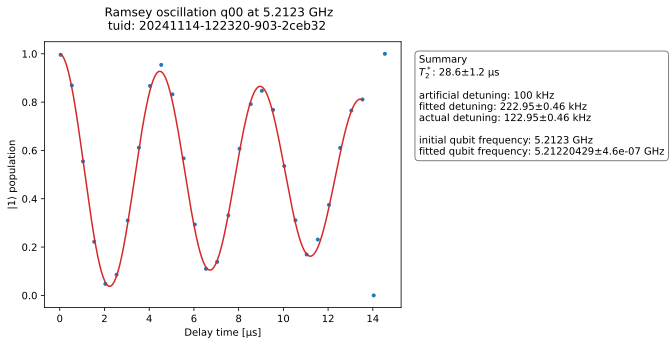

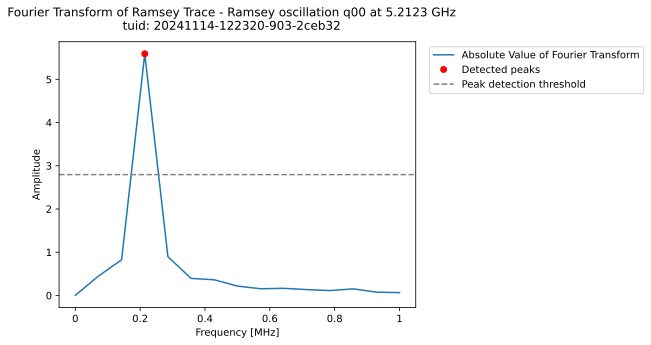

In [50]:
analysis_ramsey.display_figs_mpl()


### Echo dephasing time $T_2^E$

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 46



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

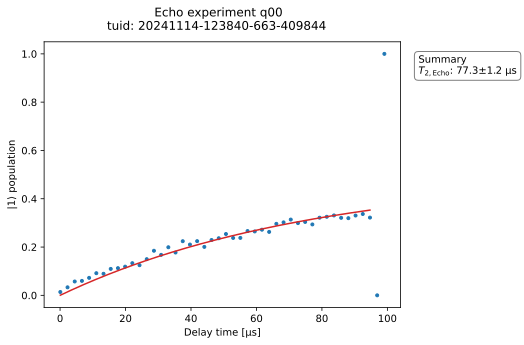

In [54]:
times = np.arange(80e-9, 100e-6,2.2e-6)

analysis_echo = meas.single_qubit_timedomain.measure_echo(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    times=times,
)
analysis_echo.display_figs_mpl()


We can store the measured coherence times in the quantities of interest (qoi) submodule of the `superconducting_qubit_tools.device_under_test.transmon_element.TransmonElement`.
This will allow us to use these values when reporting device summaries.
The reporting module is described in Tutorial 8.

In [55]:
q0.qoi.t1(analysis_t1.quantities_of_interest["T1"].nominal_value)
q0.qoi.t2(analysis_ramsey.quantities_of_interest["T2*"].nominal_value)
q0.qoi.t2_echo(analysis_echo.quantities_of_interest["t2_echo"].nominal_value)

# 2. Basic single-qubit control

Where only a coarse calibration was required to determine the coherence times, one typically needs fine calibrations before gates are suitable to use in more sophisticated experiments.

To calibrate single-qubit control pulses, we need to determine the pulse amplitude and frequency.
Because for transmon systems the 1-2 transition is close by, one typically uses DRAG pulses [Motzoi 2009] that have an extra control parameter to mitigate leakage to the second excited state and phase errors that need to be calibrated.

**Note:**
Big X/Y stands for pi-pulse around x/y-axis. Samll x/y stands for pi/2-pulse around x/y-axis.

**--------------- You tasks in this Section ---------------**

**2.1** There are three major sources of errors affect the performance of the single-qubit gate. Can you identify them and outline the mitagation strategies?
Detuned freq, Possiblity to go to 2nd excited state, Diff in pulse amp. Ramsey experiments, motzoi calibration, flipping exp

**----------------------------------------------------------**

## The AllXY experiment

A simple experiment that can be used by a trained experimentalist to quickly diagnose gate errors is the AllXY experiment `superconducting_qubit_tools.measurement_functions.single_qubit_timedomain.measure_allxy`.
This experiment consists of pairs of control pulses arranged in a specific pattern so that different gate errors result in different syndromes.
It is described in detail in [Reed 2013].

If, for example the pulse amplitude is slightly off, we will see a slope in the AllXY experiment and if a pulse is detuned, we will see a zigzag pattern.
Although the AllXY experiment does not provide quantitative information on the gate performance, it is invaluable for quickly getting a qualitative grip on the type and order of magnitude of pulse errors.

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 index 
Batch size limit: 42



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

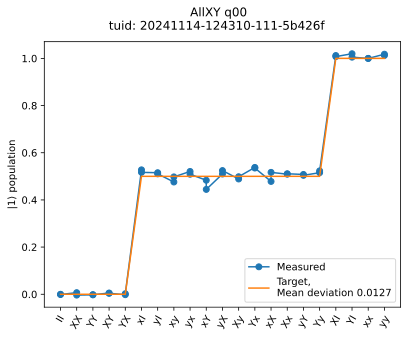

In [56]:
analyzed_dset = meas.single_qubit_timedomain.measure_allxy(
    quantum_device=quantum_device,
    qubit_name=q0.name,
)
analyzed_dset.display_figs_mpl()

The observed error is consistent with a detuning error.
We can change the detuning a bit and see how this affects the syndrome of the AllXY.

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 index 
Batch size limit: 42



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

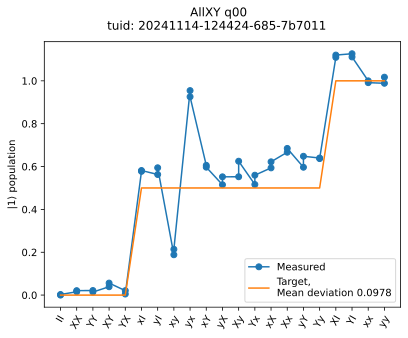

In [57]:
q0.clock_freqs.f01(q0.clock_freqs.f01()+5e6)

analyzed_dset = meas.single_qubit_timedomain.measure_allxy(
    quantum_device=quantum_device,
    qubit_name=q0.name,
)
analyzed_dset.display_figs_mpl()

In [58]:
q0.clock_freqs.f01(f01_guess)

In principle one can use the AllXY experiment to manually tune up the pulses.
However, it is often better to follow a structured approach.
Such a structured approach to tuning up the pulses is shown below.

## Fine-tuning the qubit frequency using Ramsey experiments

After having a decent $\pi$-pulse amplitude from the Rabi experiment, the first thing to calibrate is the frequency.
The frequency of oscillations in a Ramsey experiment corresponds directly to the detuning between the control pulse and the transition frequency that is being driven.

The `superconducting_qubit_tools.calibration_functions.single_qubit_timedomain.calibrate_qubit_frequency_ramsey` function automatically calibrates the qubit frequency by doing repeated Ramsey experiments.
Beware that the dynamic range in frequency of this method is limited by the Nyquist frequency set by the sampling rate of the Ramsey experiment.

**Note:**
You can change the `artificial_detuning` to observe the pattern, the oscilatory behaviour will disappear once it is on resonace with the qubit. The range is roughly 10kHz to 2MHz. 
You can attampt multiple times. Can you figure out a strategy to calibrate this with as few attampts as possible?

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 49



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

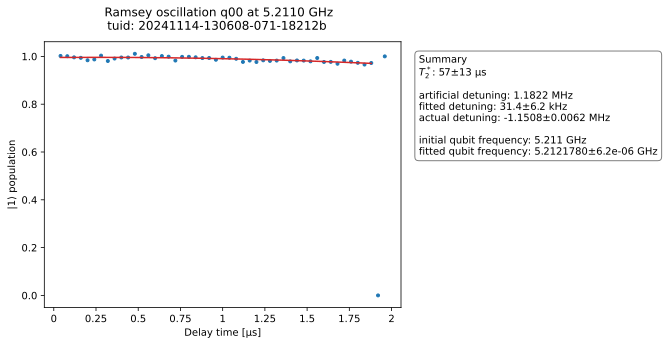

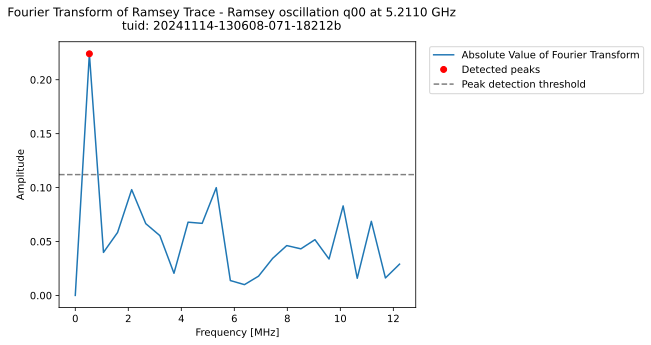

In [69]:
times = np.arange(40e-9, 2e-6, 0.04e-6)
q0.clock_freqs.f01(f01_guess-13e5)
analysis_ramsey = meas.single_qubit_timedomain.measure_ramsey(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    times=times,
    artificial_detuning=1182.2e3, # unit in Hz
)
analysis_ramsey.display_figs_mpl()

**Write down the calibrated qubit frequency here:** 

In [70]:
detuning = 1172.2e3 # -13e2 # unit in kHz
q0.clock_freqs.f01(f01_guess+detuning)

Now we will recalibrate the pi-pulse amplitude and attampt the All-XY measurement once more.

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 mw_G_amp 
Batch size limit: 31



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

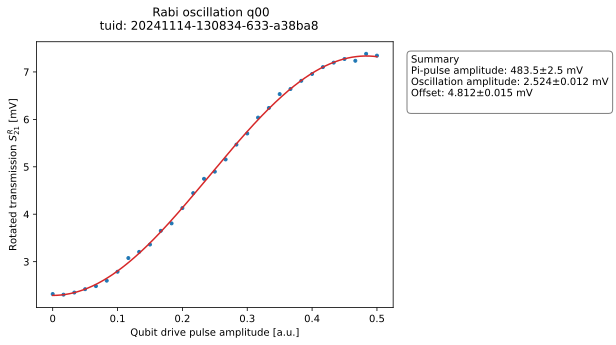

In [71]:
analyzed_rabi = meas.single_qubit_timedomain.measure_rabi(
    quantum_device=quantum_device,
    qubit_name=q0.name,
    amplitudes=np.linspace(0, .5, 31),
)
analyzed_rabi.display_figs_mpl()
q0.rxy.amp180(analyzed_rabi.quantities_of_interest['Pi-pulse amplitude'].nominal_value)

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 index 
Batch size limit: 42



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

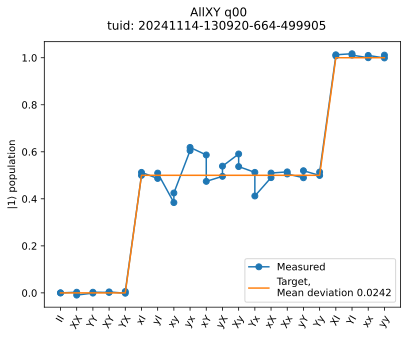

In [72]:
analyzed_dset = meas.single_qubit_timedomain.measure_allxy(
    quantum_device=quantum_device,
    qubit_name=q0.name,
)
analyzed_dset.display_figs_mpl()

We observe the errors are slightly redueced, but the deviation is still significant in the middle combinations (xY,yX and so on), suggesting that more calirbation is needed.

## The Motzoi calibration

When we apply pulses to the qubit, we do not want to promote it into the second excited state of the Transmon qubit.
The probability for leakage out of the computational subspace can be reduced by generalizing Gaussian pulses to DRAG pulse [Motzoi 2009].
To find the ideal configuration, we need to measure the Motzoi parameter and calibrate the qubit accordingly.

**Warning**: Parameter interdependence

Both the Motzoi parameter and the detuning affect the same syndromes ($xY$ and $yX$) in the AllXY experiment.
One has to calibrate the frequency before using this protocol to calibrate the Motzoi parameter.

In [ ]:
success = cal.single_qubit_timedomain.calibrate_motzoi_xy_sequence(
    quantum_device=quantum_device,
    qubit_name=q0.name,
)

## The flipping experiment

After calibrating the pulse amplitude using the Rabi, the frequency using the Ramsey experiment, and the Motzoi parameter using the $xY$-$yX$ experiment we want to fine-tune the pulse amplitude.

The pulse amplitude can be fine-tuned by amplifying the error.
The simplest experiment that amplifies this particular error is the flipping experiment (`measurement_functions.single_qubit_timedomain.measure_flipping`).
This experiment works by bringing the qubit to the equator with a $\pi/2$-pulse followed by a 2N amount of $\pi$-pulses (N flips).
If the $\pi$-pulses are correctly calibrated the qubit will remain on the equator, however if the amplitude of the pulse deviates slightly the qubit will rotate with each flip.
From the rate of this rotation the pulse amplitude can be adjusted.
This can be done automatically using `calibration_functions.single_qubit_timedomain.calibrate_pulse_amplitude_flipping`.

In [ ]:
success = cal.single_qubit_timedomain.calibrate_pulse_amplitude_flipping(
    quantum_device, qubit_name=q0.name, meas_ctrl=meas_ctrl
)

### Verifying the pulse calibration

We can now verify if our calibration was succesful by running an AllXY experiment.
If we were succesful, it should look similar to the ideal staircase pattern.

In [ ]:
analyzed_dset = meas.single_qubit_timedomain.measure_allxy(
    quantum_device=quantum_device,
    qubit_name=q0.name,
)
analyzed_dset.display_figs_mpl()

# 3. Single-qubit randomized benchmarking

## Single-qubit Randomized Benchmarking

The simplest RB protocol is the Standard RB, which allows to estimate the average fidelity of the gates in the Clifford group. From this metric, the average fidelity of the single-qubit physical gates is extracted. The average single-qubit gate fidelity can be obtained by running:

**--------------- You tasks in this Section ---------------**

**3.1** What shape, starting and ending values should the RB sequence results be?
**3.2** How many random seeds would you need for the averaged results to be resembling your prediction? Try number smaller than 100.

**----------------------------------------------------------**

In [ ]:
from superconducting_qubit_tools.measurement_functions.benchmarking import (
    measure_single_qubit_randomized_benchmarking
)
analysis_obj = measure_single_qubit_randomized_benchmarking(
    quantum_device, qubit_name=q0.name,number_of_cliffords = 2 ** np.arange(11),
      number_of_seeds = 13,repetitions_per_seed = 5
)
analysis_obj.display_figs_mpl()

The quantities of interest (QoI) are described in the docstring of `StandardRBAnalysis`. The most important one is
the `average_gate_fidelity`, which is average single-qubit gate fidelity and it has been printed in the previous cell.

To set up the measured gate fidelity to the quantum device just run:

In [ ]:
q0.qoi.gate_fidelity(analysis_obj.quantities_of_interest['average_gate_fidelity'].nominal_value)

Here you will find all you have learned about the qubits during this session:

In [ ]:
q0.print_readable_snapshot()